Generate initial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [1]:
FN = 'vocabulary-embedding'

In [2]:
seed=16

In [3]:
vocab_size = 30000

In [4]:
embedding_dim = 50

In [5]:
lower = False # dont lower case the text

In [6]:
pwd

'/home/ash1sh/headlines'

# read tokenized headlines and descriptions

In [7]:
import json
fndata = '_dataset/sample-1M.jsonl'
heads = []
desc = []
counter = 0
with open(fndata) as f:
        for line in f:
            if counter < 50000:
                jdata = json.loads(line)    # for json lines file, loading line by line
                heads.append(jdata["title"].lower())
                desc.append(jdata["content"].lower())
                counter +=1

In [8]:
if lower:
    heads = [h.lower() for h in heads]

In [9]:
if lower:
    desc = [h.lower() for h in desc]

In [10]:
i=0
heads[i]

'worcester breakfast club for veterans gives hunger its marching orders'

In [11]:
desc[i]

'veterans saluted worcester\'s first ever breakfast club for ex-soldiers which won over hearts, minds and bellies. \n \nthe worcester breakfast club for hm forces veterans met at the postal order in foregate street at 10am on saturday. \n \nthe club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders. \n \nfather-of-two dave carney, aged 43, of merrimans hill, worcester, set up the club after being inspired by other similar clubs across the country. \n \nhe said: "as you can see from the picture, we had a good response. five out of the 10 that attended said they saw the article in the newspaper and turned up. \n \n"we even had an old chap travel from droitwich and he was late on parade by three hours. \n \n"it\'s generated a lot of interest and i estimate (from other veterans who saw the article) that next month\'s meeting will attract about 20 people. onwards and upwards." \n \nhe said the management at the pub ha

In [12]:
len(desc),len(set(desc))

(50000, 48807)

In [13]:
len(heads),len(set(heads))

(50000, 48776)

# build vocabulary

In [30]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [31]:
vocab, vocabcount = get_vocab(heads+desc)

most popular tokens

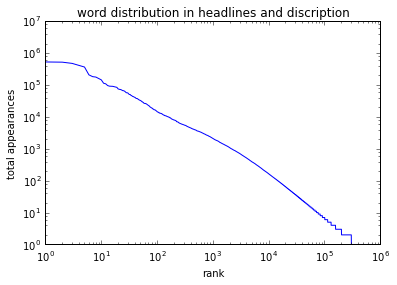

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [17]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [32]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())
    # Important changes in python 3
    # Removed dict.iteritems(), dict.iterkeys(), and dict.itervalues().
    # Instead: use dict.items(), dict.keys(), and dict.values() respectively.
    return word2idx, idx2word

In [33]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [20]:
from keras.utils.data_utils import get_file

Using TensorFlow backend.


In [21]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    !unzip {path}

Archive:  /home/ash1sh/.keras/datasets/glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [22]:
glove_name = '/home/ash1sh/headlines/glove.6B.50d.txt'
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [23]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [34]:
glove_embedding_weights.std()

0.06441042976813115

In [35]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [36]:
import numpy as np

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print ('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hashtags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print ('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.11156213689575 std 0.06439317819630448
number of tokens, in small vocab, found in glove and copied to embedding 20306 0.6768666666666666


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [37]:
glove_thr = 0.5

In [38]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [40]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print ('# of glove substitutes found', len(glove_match))

# of glove substitutes found 96166


manually check that the worst substitutions we are going to do are good enough

In [42]:
for orig, sub, score in glove_match[-10:]:
    print (score, orig,'=>', idx2word[sub])

0.5000864419742144 ghadir => con-way
0.5000744672448953 delitos => que
0.5000736205848781 leaker => bulger
0.5000615783742726 ertugrul => sartaj
0.5000567016033264 jnnurm => atc
0.5000317518856285 weserstadion => newsdesk
0.5000203629838701 maassen => anti-corruption
0.5000061289381201 titanes => re/max
0.5000039243720622 maltbie => wawrinka
0.5000033605283392 matveeva => cabling


build a lookup table of index of outside words to index of inside words

In [48]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [44]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

50000

In [46]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

50000

In [49]:
import _pickle as pickle  
with open('_dataset/%s.pkl'%FN,'wb') as fp:  
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)  

In [50]:
import _pickle as pickle  
with open('_dataset/%s.data.pkl'%FN,'wb') as fp:  
    pickle.dump((X,Y),fp,-1)  